In this dataset we make a model with Machine Learning method that can predict and clasify notes as Authentic [1] or Fake[0]. In this notebook we will cover followings things : 
- Exploratory Data Analysis
- Preprocessing Data
- Model building
- Prediction

# **Import Package**

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, learning_curve, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor, XGBClassifier
from scipy.stats import randint, uniform

# JCOPML Package
from jcopml.plot import plot_missing_value
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.tuning import random_search_params as rsp
from jcopml.feature_importance import mean_loss_decrease
from jcopml.feature_importance import mean_score_decrease
from jcopml.tuning import bayes_search_params as bsp
from jcopml.tuning import grid_search_params as gsp

# **Import Dataset**

In [2]:
df = pd.read_csv("data/BankNoteAuthentication.csv")
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [4]:
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


# **Exploratory Data Analysis (EDA)**

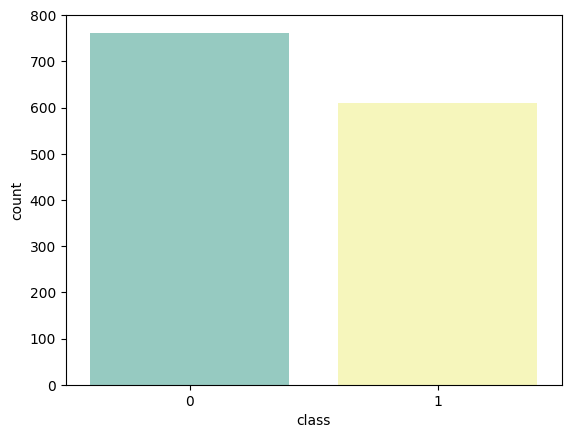

In [16]:
sns.countplot(x='class', data=df, hue='class', palette='Set3', legend=False)
plt.show()

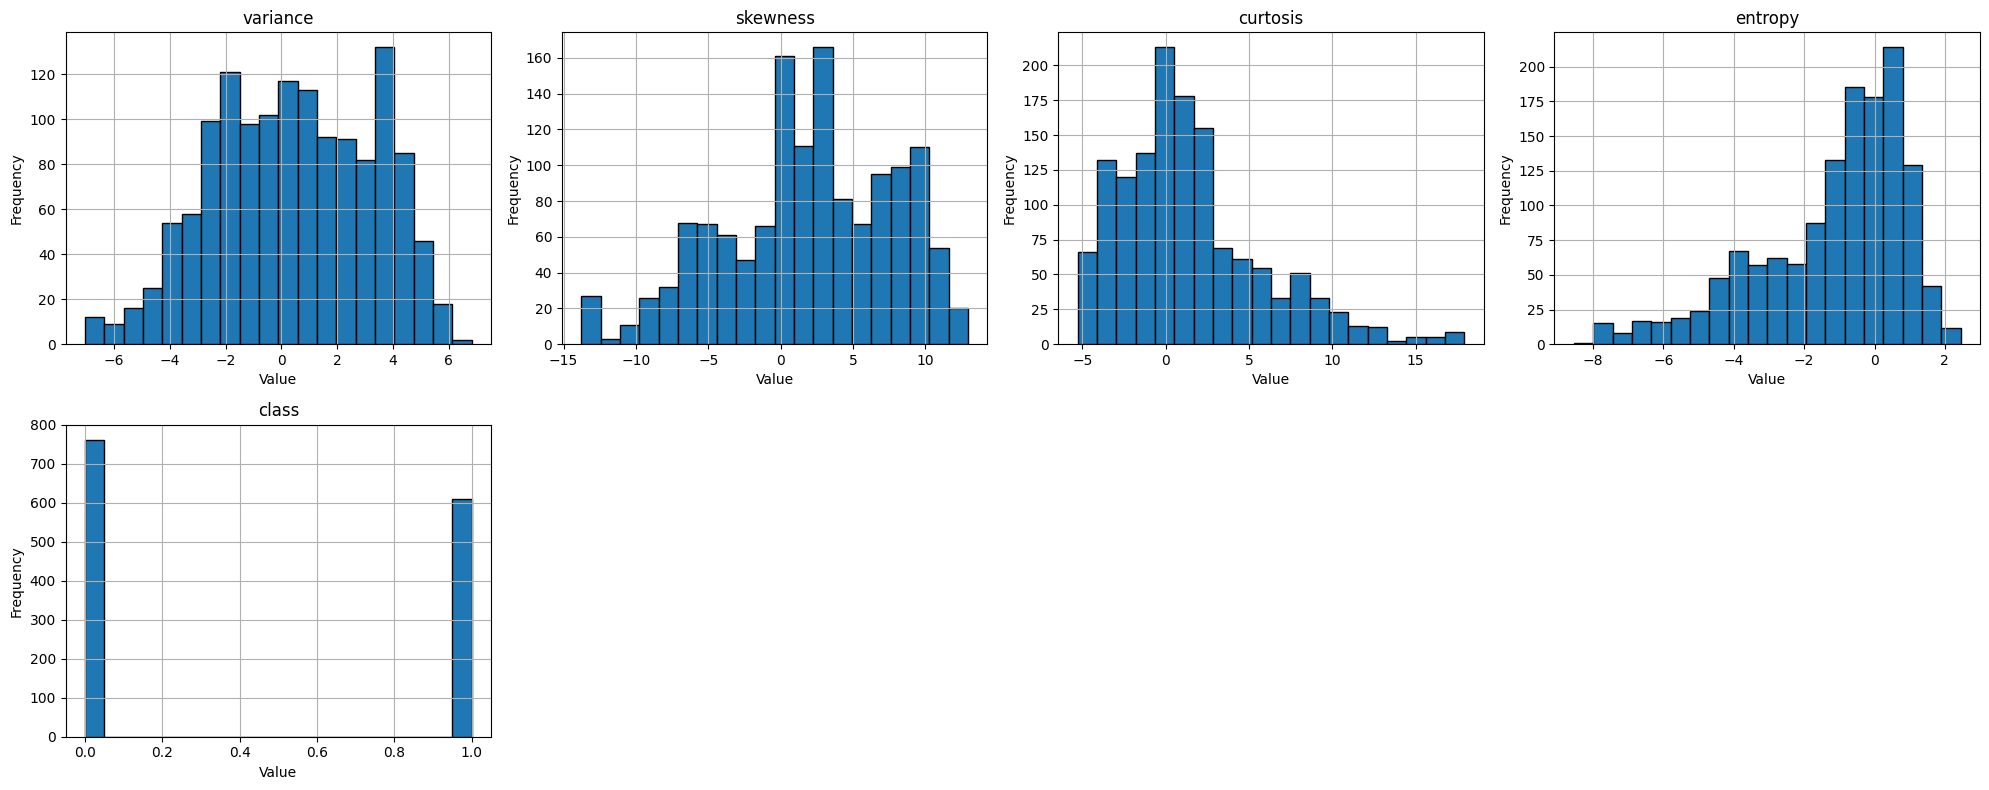

In [17]:
num_vars = df.shape[1]
n_cols = 4 
n_rows = -(-num_vars // n_cols) 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

axes = axes.flatten()
 
for i, column in enumerate(df.columns):
    df[column].hist(ax=axes[i], bins=20, edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
 
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
 
plt.tight_layout()
plt.show()

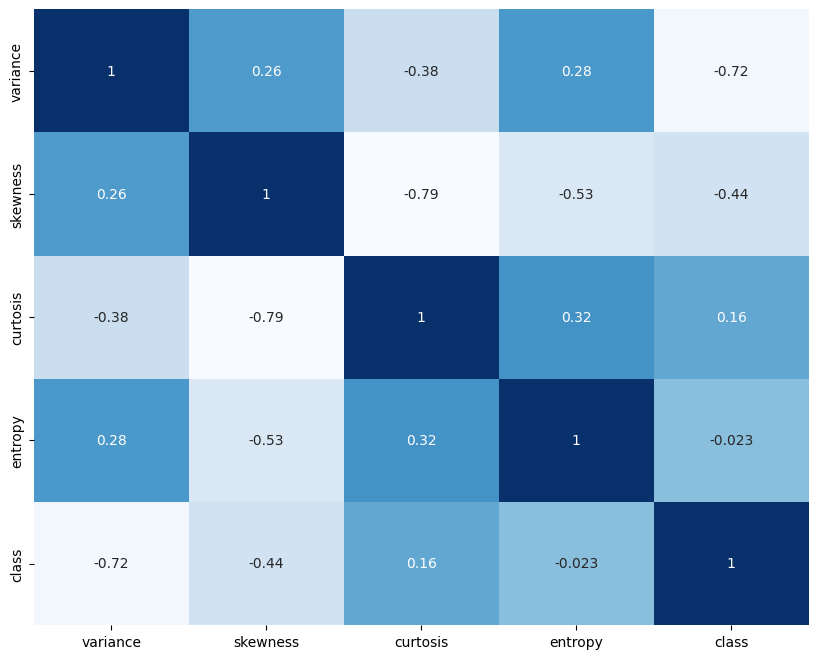

In [19]:
plt.figure(figsize=(10, 8))
banknote_corr = df.corr()
sns.heatmap(banknote_corr, annot=True, cmap='Blues', cbar=False)
plt.show()

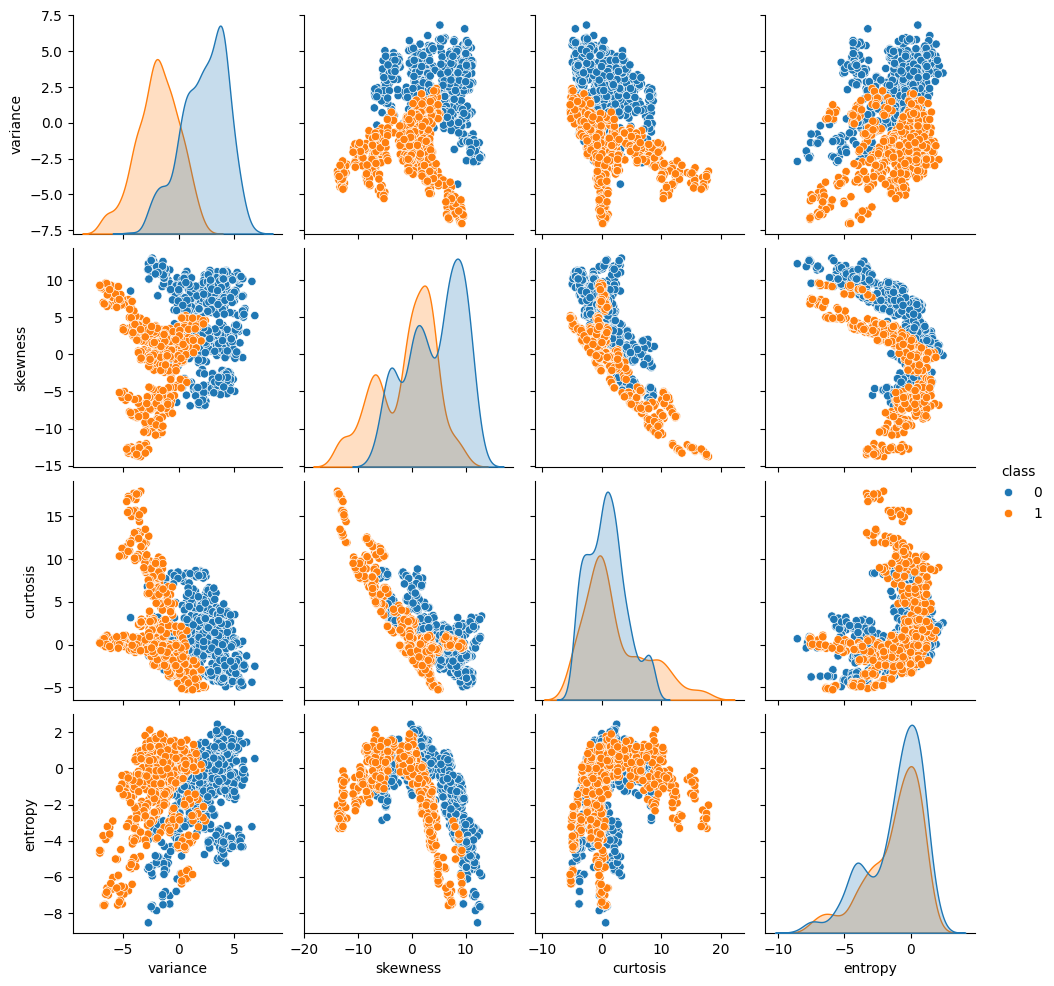

In [21]:
sns.pairplot(df, hue='class')
plt.show()

# **Dataset Splitting**

In [41]:
X = df.drop(columns=['class'], axis=1)
y = df['class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1097, 4), (1097,), (275, 4), (275,))

# **Preprocessing**

In [64]:
preprocessor = ColumnTransformer([ 
    ('numeric', num_pipe(scaling='standard'), X_train.columns)
])

In [99]:
xgb = Pipeline([ 
    ("prep", preprocessor),
    ("algo", XGBClassifier())  
])

# score_xgb= cross_val_score(xgb, X_train, y_train, cv=3)
# print(f"Cross-Validation Scores: {score_xgb}")
# print(f"Mean CV Score: {score_xgb.mean()}")
xgb.fit(X_train, y_train)
print(f"Score Training      : {xgb.score(X_train, y_train)}")
print(f"Score Testing       : {xgb.score(X_val, y_val)}")

Score Training      : 1.0
Score Testing       : 0.9963636363636363


In [65]:
svc = Pipeline([ 
    ("prep", preprocessor),
    ("algo", SVC(probability=True, gamma='auto'))  
])

svc.fit(X_train, y_train)
print(f"Score Training      : {svc.score(X_train, y_train)}")
print(f"Score Testing       : {svc.score(X_val, y_val)}")

Score Training      : 1.0
Score Testing       : 1.0


In [48]:
k_fold = StratifiedKFold(n_splits=10)
svc = SVC(probability=True, gamma='auto')
cv  = cross_val_score(svc, X_train, y_train, cv=k_fold)
print(f'Model : {svc}, {cv}, CV Score : {cv.mean()}')

Model : SVC(gamma='auto', probability=True), [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], CV Score : 1.0


# **Model Evaluation**

In [100]:
print("xgb Evaluation : ")
y_val_pred_xgb =xgb.predict(X_val)
report_xgb = classification_report(y_val, y_val_pred_xgb)
print("Classification Report:")
print(report_xgb)

cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
print("\nConfusion Matrix xgb :")
print(cm_xgb)
print("xgb Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_xgb, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_xgb, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_xgb, average='macro', zero_division=0):.4f}")


print("\n")
print("SVC Evaluation : ")
y_val_pred_svc = svc.predict(X_val)
report_svc = classification_report(y_val, y_val_pred_svc)
print("Classification Report:")
print(report_svc)

cm_svc = confusion_matrix(y_val, y_val_pred_svc)
print("\nConfusion Matrix SVC :")
print(cm_svc)
print("\nSVC Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_svc, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_svc, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_svc, average='macro', zero_division=0):.4f}")

xgb Evaluation : 
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       148
           1       1.00      0.99      1.00       127

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275


Confusion Matrix xgb :
[[148   0]
 [  1 126]]
xgb Evaluation :
Precision (macro): 0.9966
Recall (macro): 0.9961
F1-Score (macro): 0.9963


SVC Evaluation : 
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00       127

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275


Confusion Matrix SVC :
[[148   0]
 [  0 127]]

SVC Evaluation :
Precision (macro): 1.0000
Recall (macro): 1.0000
F1-Score (

In [75]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="r",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

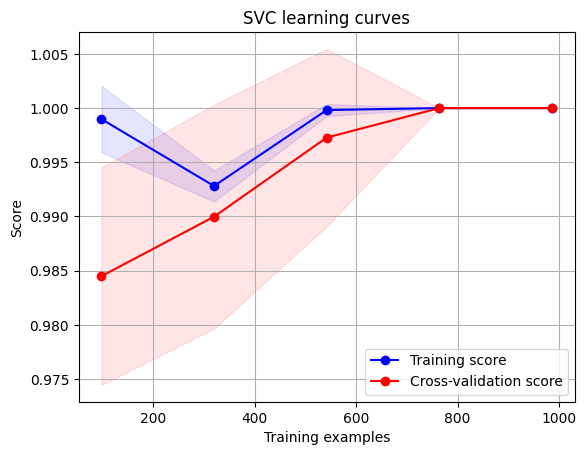

In [ ]:
svc_learning_curves = plot_learning_curve(svc,"SVC learning curves",X_train,y_train,cv=k_fold)

c:\Users\windows\Documents\Python\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


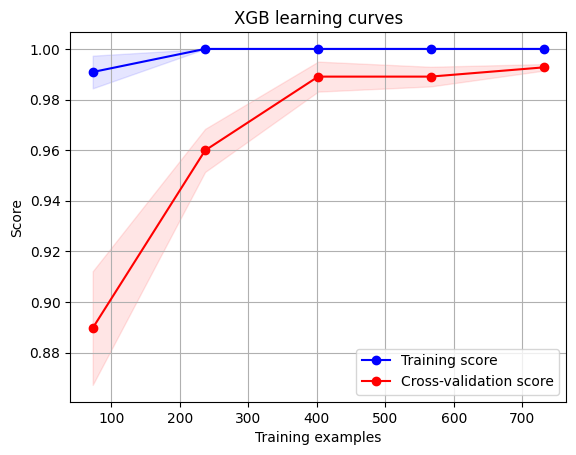

In [102]:
xgb_learning_curves = plot_learning_curve(xgb,"XGB learning curves",X_train,y_train,cv=3)

In [104]:
y_pred_svc = clf_svc.predict(X_val)
y_pred_svc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0])

<Axes: >

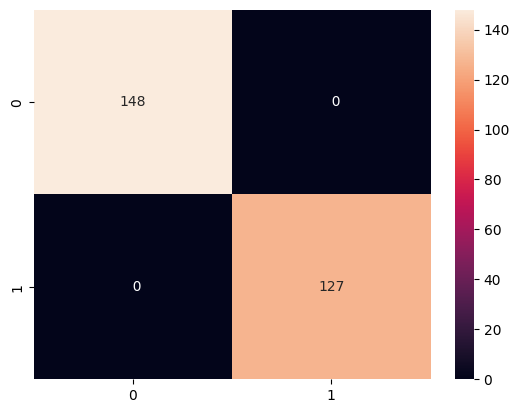

In [105]:
sns.heatmap(confusion_matrix(y_val, y_pred_svc), annot=True, fmt='3.0f')

<Axes: >

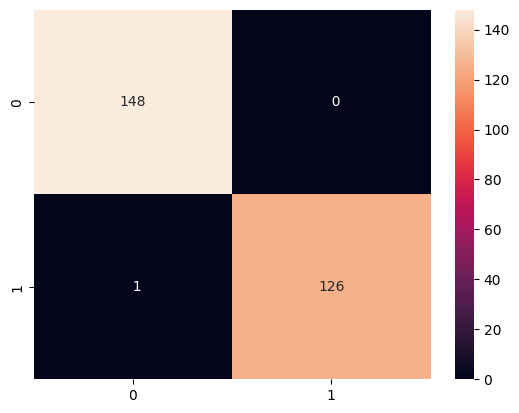

In [106]:
y_pred_xgb = xgb.predict(X_val)
sns.heatmap(confusion_matrix(y_val, y_pred_xgb), annot=True, fmt='3.0f')

### **Cool, Model for Bank Note Authentication Dataset with 100% Accuracy with SVC**